## 아기울음 소리 분류 모델: CRNN

데이터 전처리 과정에서 각 음성의 성조, 진폭, 등에 따른 패턴을 추출하였다.

각 상태(hungry, sad, ...etc)에 따른 서로 다른 패턴의 특징을 효과적으로 감지하고 분류하기 위해 CRNN 아키텍쳐를 가지는 모델을 직접 설계하여 사용하였다.

본 문서는 아기울음 소리 원인 분류를 위해 CRNN 모델 정의 및 학습, 예측을 수행하는 내용을 담고 있다.

> CRNN 모델의 정확도는 84%로 최종적으로 사용된 모델인 ResNet50보다 9% 낮은 정확도를 보인다.


In [ ]:
# Load packages
import os
import librosa
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization

In [ ]:
# 경로 설정
main_dir = '/Users/jaewone/developer/tensorflow/baby-cry-classification'
data_dir = os.path.join(main_dir, 'data')

sys.path.append(main_dir)

In [ ]:
# 하이퍼 파라미터

# MFCC 계수 개수 설정
n_mfcc = 12

In [ ]:
# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)


# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)),
             (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42)


# 첫 번째 모델 생성
model1 = Sequential()

# Convolutional Layer 추가
model1.add(Conv2D(64, (3, 3), activation='relu',
           input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same'))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))  # Dropout 추가

model1.add(Flatten())


# LSTM 레이어 변경
model1.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))
model1.add(LSTM(128, return_sequences=True))
model1.add(Dropout(0.5))
model1.add(LSTM(64, return_sequences=True))
model1.add(LSTM(32))
model1.add(Dropout(0.5))

# Output 레이어 변경
model1.add(Dense(num_classes, activation='softmax'))

# 모델1 컴파일
model1.compile(loss='categorical_crossentropy',
               optimizer='adam', metrics=['accuracy'])


# 두 번째 모델 생성
model2 = Sequential()

# Convolutional Layer 추가
model2.add(Conv2D(64, (3, 3), activation='relu',
           input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))  # Dropout 추가

model2.add(Flatten())


# LSTM 레이어 변경
model2.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(32))
model2.add(Dropout(0.5))

# Output 레이어 변경
model2.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
initial_lr = 0.001  # 초기 학습률 설정


# Learning Rate를 조정할 함수 정의
def lr_schedule(epoch):
    decay_rate = 0.9   # 학습률 감소 비율
    decay_steps = 10    # 학습률 감소 주기 (에폭 단위)
    lr = initial_lr * decay_rate**(epoch // decay_steps)
    return lr


# Learning Rate Scheduler 콜백 생성
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# 모델 컴파일
model2.compile(loss='categorical_crossentropy',
               optimizer='adam', metrics=['accuracy'])

# 두 모델 학습
history1 = model1.fit(X_train, y_train, epochs=200, batch_size=32,
                      validation_split=0.1, callbacks=[LearningRateScheduler(lr_schedule)])
history2 = model2.fit(X_train, y_train, epochs=200, batch_size=32,
                      validation_split=0.1, callbacks=[LearningRateScheduler(lr_schedule)])

# 각 모델의 예측 결과 가져오기
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)

# 예측 결과 앙상블 (여기서는 간단히 평균 값을 사용)
ensemble_predictions = (predictions1 + predictions2) / 2

# 최종 예측 결과 평가
ensemble_accuracy = np.mean(
    np.argmax(ensemble_predictions, axis=1) == np.argmax(y_test, axis=1))
print("Ensemble Accuracy:", ensemble_accuracy)

Epoch 1/200
194/194 [==============================] - 22s 18ms/step - loss: 1.5961 - accuracy: 0.3794 - val_loss: 1.4486 - val_accuracy: 0.4572 - lr: 0.0010
Epoch 2/200
194/194 [==============================] - 2s 12ms/step - loss: 1.4480 - accuracy: 0.4548 - val_loss: 1.3580 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 3/200
194/194 [==============================] - 3s 17ms/step - loss: 1.3652 - accuracy: 0.4826 - val_loss: 1.2836 - val_accuracy: 0.5254 - lr: 0.0010
Epoch 4/200
194/194 [==============================] - 3s 16ms/step - loss: 1.3283 - accuracy: 0.5050 - val_loss: 1.2133 - val_accuracy: 0.5544 - lr: 0.0010
Epoch 5/200
194/194 [==============================] - 2s 10ms/step - loss: 1.2672 - accuracy: 0.5403 - val_loss: 1.2307 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 6/200
194/194 [==============================] - 2s 10ms/step - loss: 1.2195 - accuracy: 0.5513 - val_loss: 1.1418 - val_accuracy: 0.5936 - lr: 0.0010
Epoch 7/200
194/194 [==============================] - 2s

### 학습 및 검증 정확도를 시각적으로 확인한다.


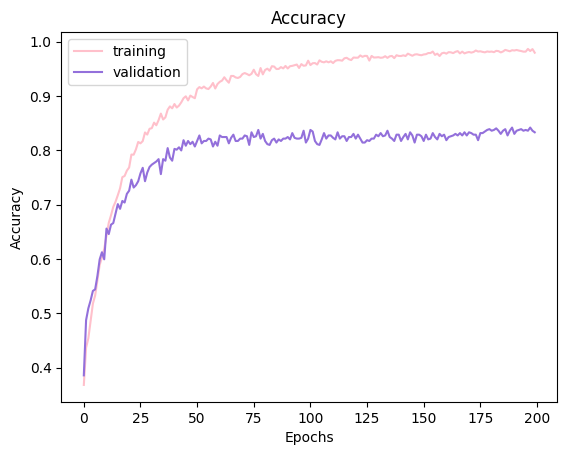

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'], label='training', color='pink')
plt.plot(history2.history['val_accuracy'],
         label='validation', color='mediumpurple')  # 검증 데이터 정확도 추가
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()